# Анализ клиентов сети фитнес-центров 

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Задача — провести анализ и подготовить план действий по удержанию клиентов.

 План:
 - научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
 - сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
 - проанализировать основные признаки, наиболее сильно влияющие на отток;
 - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

## Шаг 1. Загрузка данных

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import math as mth
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [17]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

 - 'Churn' — факт оттока в текущем месяце;

Данные пользователя за предыдущий до проверки факта оттока месяц:
 - 'gender' — пол
 - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
 - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
 - 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
 - 'Phone' — наличие контактного телефона
 - 'Age' — возраст
 - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
 - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
 - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
 - 'Group_visits' — факт посещения групповых занятий
 - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
 - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
 - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [18]:
gym_churn.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [19]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


### Вывод:

Таблица gym_churn имеет размер 4000 строк и 14 столбцов. Пропуски в таблице отсутствуют. Тип данных вещественные и целочисленные.

## Шаг 2. Исследовательский анализ данных (EDA)

In [20]:
#изучим распределение среднего и стандартного отклонения
for name in gym_churn.columns.values:
    print()
    print(name)
    print("Среднее:",round(gym_churn[name].describe()[1],2))
    print("Стнд. отклонение:",round(gym_churn[name].describe()[2], 2))


gender
Среднее: 0.51
Стнд. отклонение: 0.5

Near_Location
Среднее: 0.85
Стнд. отклонение: 0.36

Partner
Среднее: 0.49
Стнд. отклонение: 0.5

Promo_friends
Среднее: 0.31
Стнд. отклонение: 0.46

Phone
Среднее: 0.9
Стнд. отклонение: 0.3

Contract_period
Среднее: 4.68
Стнд. отклонение: 4.55

Group_visits
Среднее: 0.41
Стнд. отклонение: 0.49

Age
Среднее: 29.18
Стнд. отклонение: 3.26

Avg_additional_charges_total
Среднее: 146.94
Стнд. отклонение: 96.36

Month_to_end_contract
Среднее: 4.32
Стнд. отклонение: 4.19

Lifetime
Среднее: 3.72
Стнд. отклонение: 3.75

Avg_class_frequency_total
Среднее: 1.88
Стнд. отклонение: 0.97

Avg_class_frequency_current_month
Среднее: 1.77
Стнд. отклонение: 1.05

Churn
Среднее: 0.27
Стнд. отклонение: 0.44


Почти все вещественные характеристики имеют достаточно большой разброс данных.

In [21]:
#изучим распределение среднего и стандартного отклонения у тех кто ушёл и тех кто остался
gym_by_churn = gym_churn.groupby('Churn').mean().transpose()

gym_by_churn

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


По основным качественным и количественным характеристикам клиенты которые ушли в отток уступают постоянным пользователям

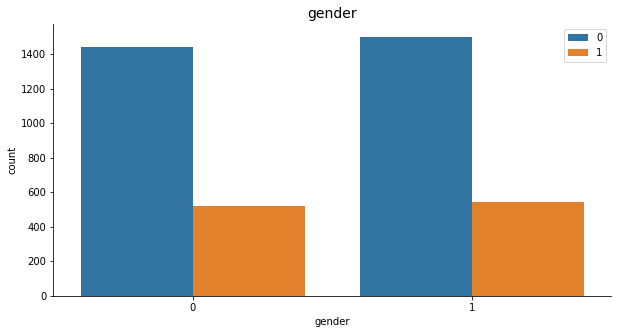

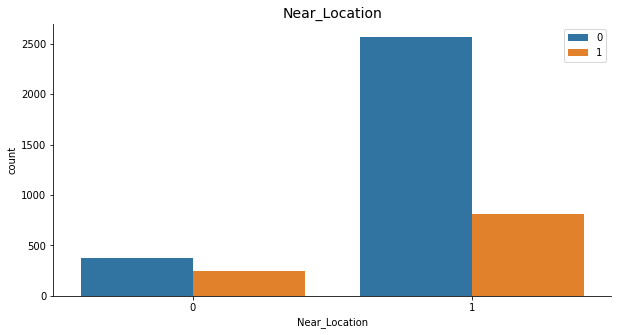

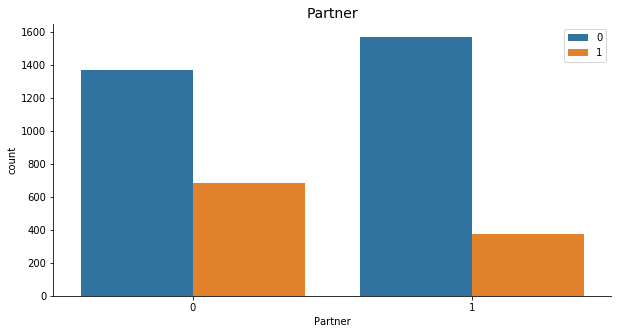

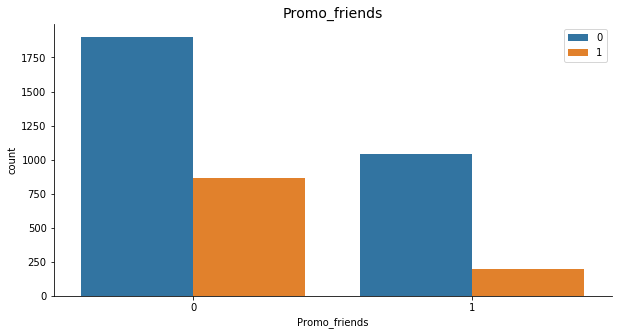

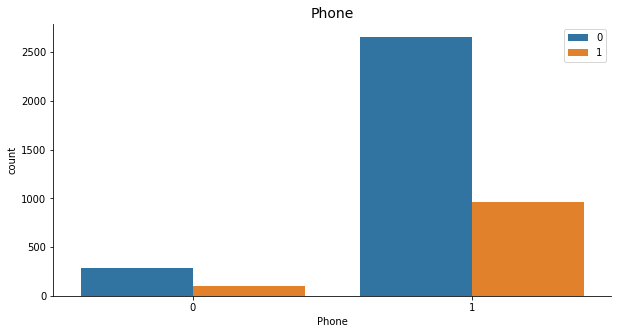

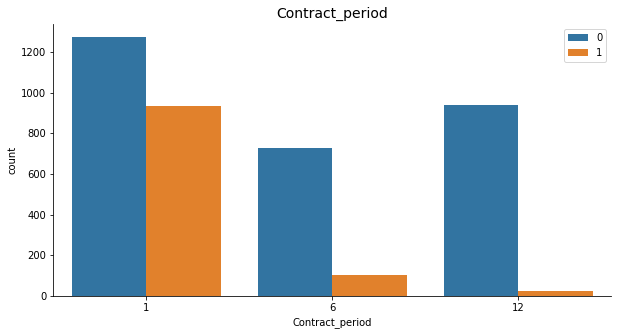

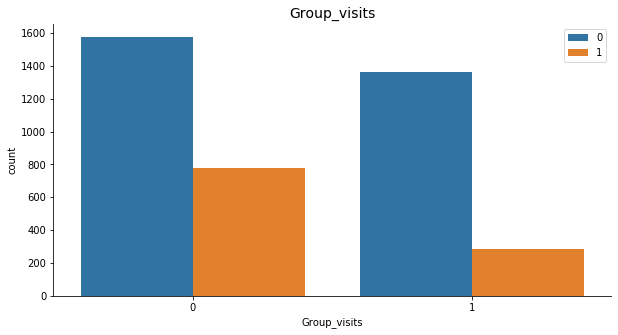

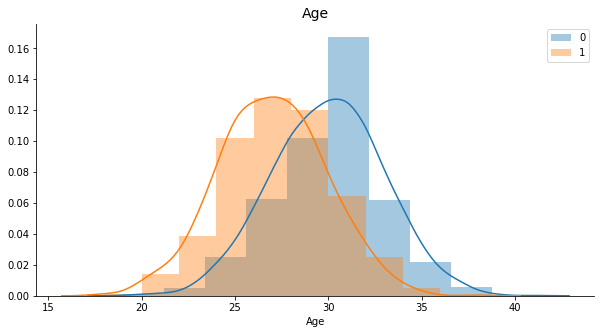

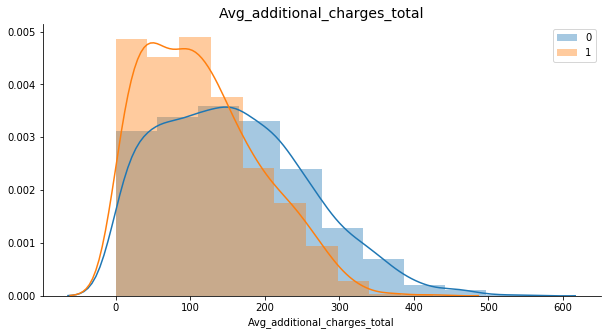

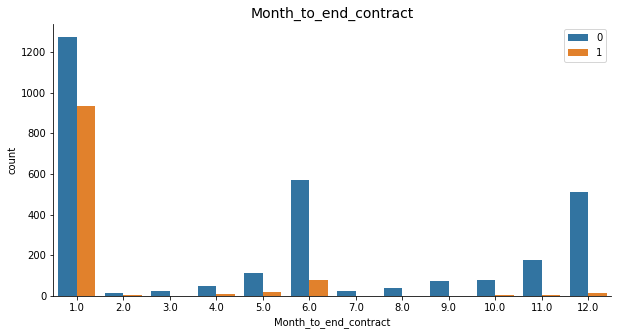

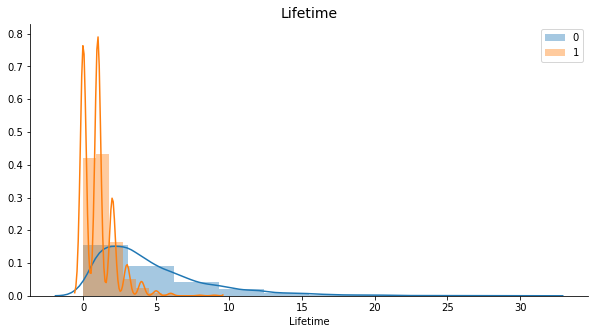

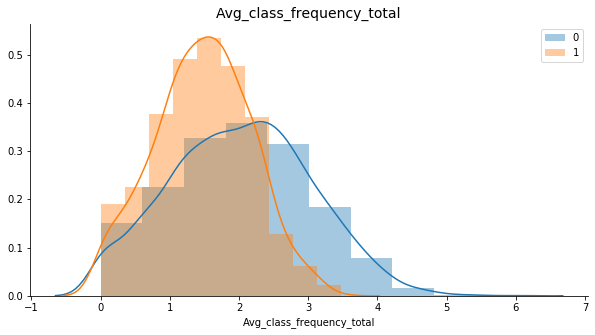

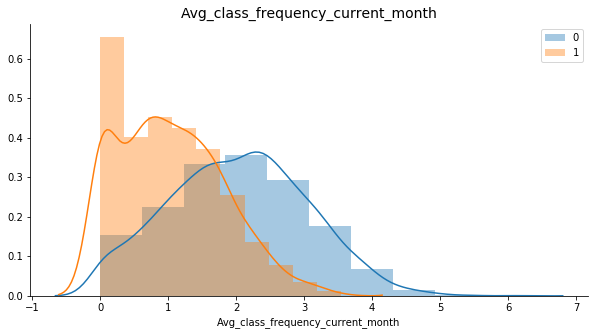

In [22]:
#гистограммы распределений тех кто ушёл и тех кто остался
colum_binar = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 
               'Contract_period', 'Group_visits', 'Month_to_end_contract', 'Churn']

for name in gym_churn.columns.values[:-1]:
    f, ax =  plt.subplots(figsize=(10, 5))
    if name in colum_binar:
            ax = sns.countplot(x = name ,hue="Churn", data = gym_churn)
            ax.set_title(name, fontsize=14)
              

    else:
     
        for type_churn in gym_churn['Churn'].unique():   
            ax = sns.distplot(gym_churn.query('Churn == @type_churn')[name], label = type_churn, bins = 10)
            ax.set_title(name, fontsize=14)
            
    sns.despine()
    plt.legend(loc = 'best')
    plt.show()

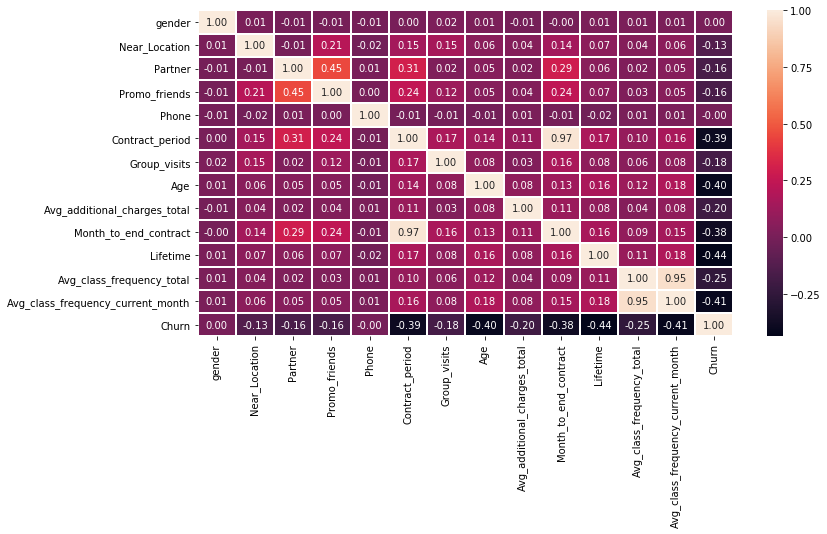

In [23]:
#корреляционная матрица
plt.figure(figsize=(12, 6))
sns.heatmap(gym_churn.corr(), annot=True, fmt='.2f', linewidths=1, linecolor='white')

plt.show()

### Выводы:
 - Распределение признаков:
 
В отток ушли те клиенты которые: живут далеко, не являются сотрудниками компании-партнёра, меньше пользуются акцией "приведи друга", с коротким сроком контракта (1 мес.), меньше посещают групповые визиты, более молодые (27 лет против 30), меньше тратящие на сопутствующие услуги (115 р. проив 158р.), до окончания контракта у них остаётся ещё около 2 месяцев, 1 месяц с момента первого обращения в фитнес-центр,  средняя частота посещений 1.47 в мес. против 2.02 в мес.,  средняя частота посещений за предыдущий месяц 1.04 в мес. против 2.02 в мес;

 - Корреляция:
 
 С фактом оттока 'Churn' - хорошо коррелируют: Lifetime (-0.44), Avg_class_frequency_current_month (-0.41), Age (-0.4), Contract_period (-0.39), Month_to_end_contract (-0.38);
 
 
 - Признаки с сильной корреляцией:
 
 Month_to_end_contract/Contract_period - 0.97, Avg_class_frequency_current_month/Avg_class_frequency_total - 0.95;
 

## Шаг 3. Модель прогнозирования оттока пользователей

Модель бинарной классификации пользователей


In [24]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop(columns = ['Churn'])
y = gym_churn['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

models = [LogisticRegression(), RandomForestClassifier(random_state = 12)]

# задаём алгоритм для нашей модели
for name in models:
    model = name

    # обучим модель
    model.fit(X_train_st, y_train)

    # воспользуемся уже обученной моделью, чтобы сделать прогнозы
    y_pred = model.predict(X_test_st)

    #проверяем метрики
    #accuracy
    acc = accuracy_score(y_test, y_test)

    #precision
    precision = precision_score (y_test,y_pred)

    #recall 
    recall = recall_score (y_test, y_pred)
    
    print(name)
    print('accuracy', round(acc,2))
    print('precision', round(precision, 2))
    print('recall', round(recall, 2))



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy 1.0
precision 0.89
recall 0.86
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)
accuracy 1.0
precision 0.86
recall 0.8


### Вывод:
Логистическая регрессия показала лучшие результаты в сравнении со Случайным лесом:
 - accuracy (1 против 1);
 - precision (0.89 против 0.88);
 - recall (0.87 против 0.79)


## Шаг 4. Сделайте кластеризацию пользователей

In [25]:
X.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078


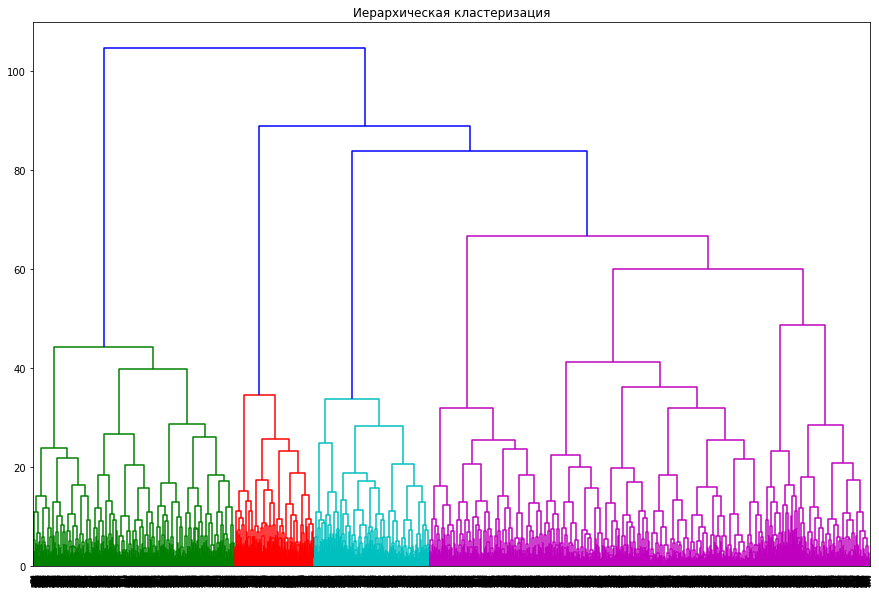

In [26]:
#матрица расстояний
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')


plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

Выделилось 4 кластера. Можно выделять от 4 до 6 кластеров

In [27]:
#K-Means 

km = KMeans(n_clusters = 5, random_state=12) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels


In [28]:
#средние значения кластеров
gym_churn.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.564858,0.977594,0.343160,0.221698,1.0,2.550708,0.472877,30.122642,161.268043,2.349057,4.916274,2.812928,2.807517,0.074292
1,0.498531,0.960823,0.783546,0.575906,1.0,10.854065,0.539667,29.972576,161.128963,9.920666,4.723800,2.003225,1.996705,0.027424
2,0.497041,0.000000,0.461538,0.078895,1.0,2.378698,0.218935,28.479290,135.631940,2.224852,2.812623,1.662253,1.480228,0.441815
3,0.483845,1.000000,0.355412,0.242326,1.0,1.962843,0.340065,28.144588,130.918569,1.872375,2.390953,1.233389,0.995856,0.519386
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


Кластеры 3 и 4 наиболее подвержены риску оттока. Отличия наблюдаются по многим параметрам, возраст, средний чек, наличие групповых визитов и т.д.

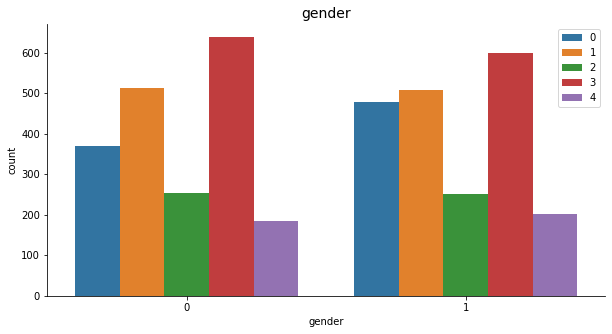

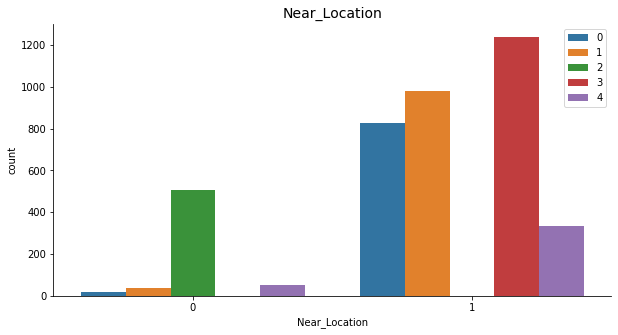

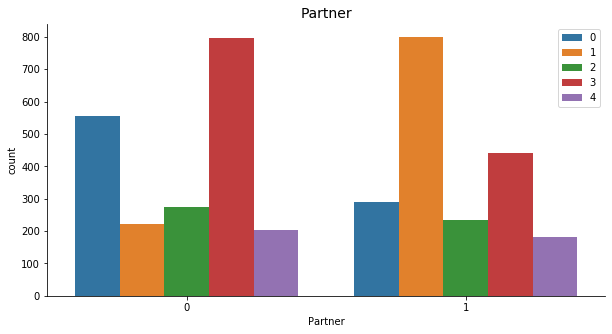

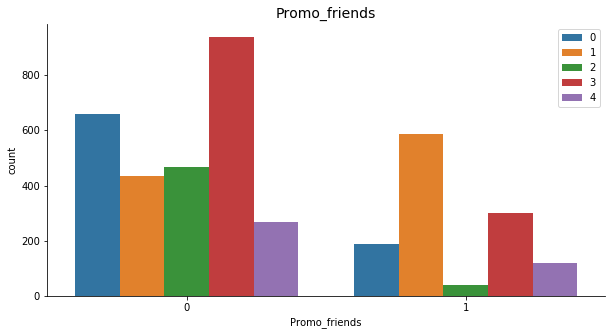

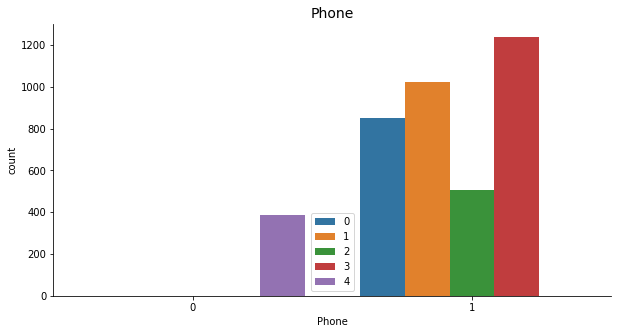

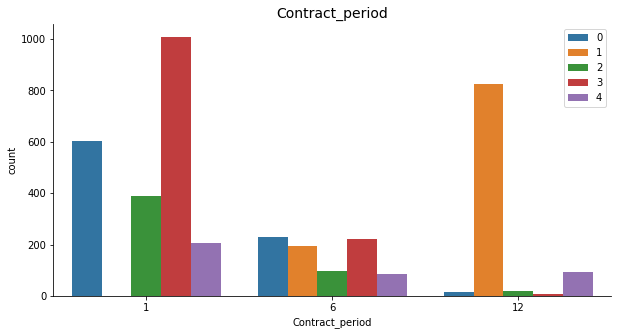

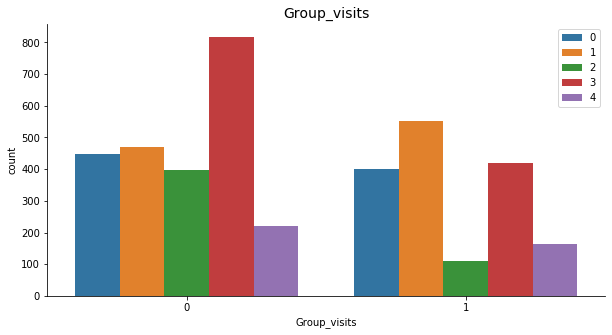

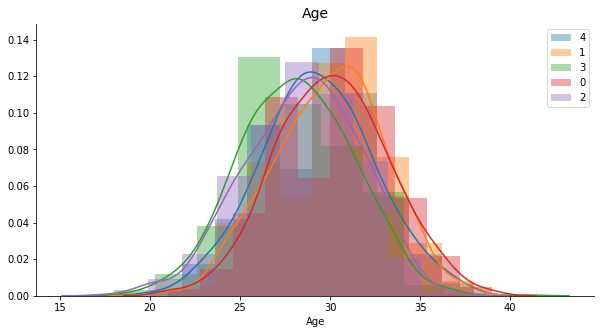

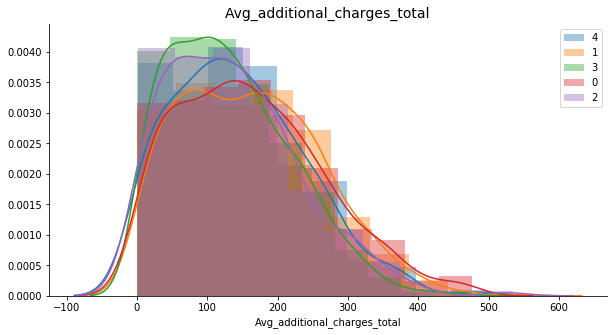

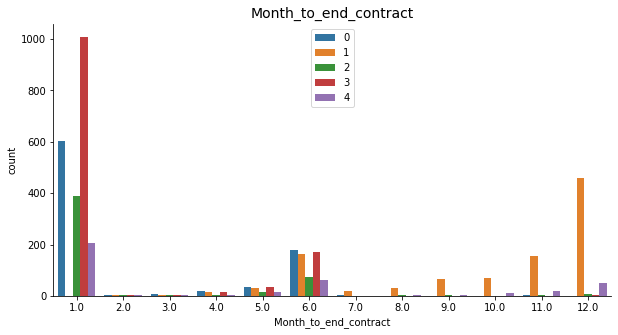

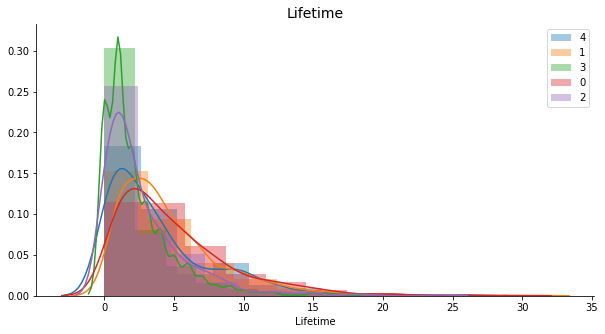

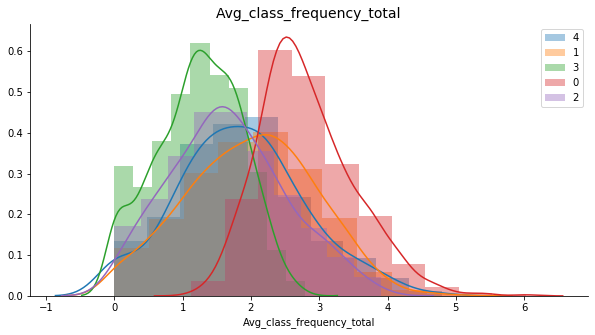

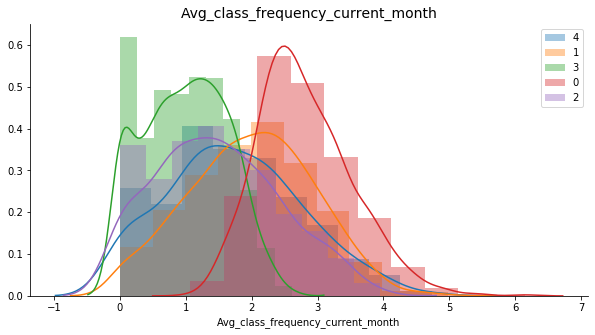

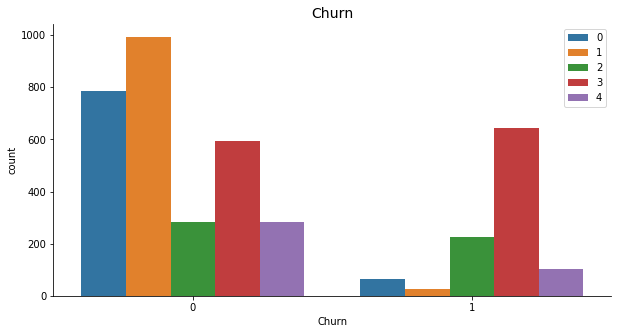

In [29]:
colum_binar = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 
               'Contract_period', 'Group_visits', 'Month_to_end_contract', 'Churn']


#гистограммы распредлений признаков


for name in gym_churn.columns.values[:-1]:
    f, ax =  plt.subplots(figsize=(10, 5))
    if name in colum_binar:
            ax = sns.countplot(x = name ,hue="cluster_km", data = gym_churn)
            ax.set_title(name, fontsize=14)
            #ax.set_xlabel('количество мест', fontsize=10)
            #ax.set_ylabel('количество', fontsize=10)    

    else:
     
        for type_cluster in gym_churn['cluster_km'].unique():   
            ax = sns.distplot(gym_churn.query('cluster_km == @type_cluster')[name], label = type_cluster, bins = 10)
            ax.set_title(name, fontsize=14)
            
    sns.despine()
    plt.legend(loc = 'best')
    plt.show()


In [30]:
#доля оттока по кластерам
gym_churn_by_class = gym_churn.groupby('cluster_km').agg({'Churn':['sum', 'count']}).reset_index()

gym_churn_by_class.columns = ['_'.join([str(i) for i in col]) for col in gym_churn_by_class.columns.values]

gym_churn_by_class['out_prop'] = round(gym_churn_by_class['Churn_sum']/gym_churn_by_class['Churn_count'],2)

gym_churn_by_class.sort_values('out_prop')

,cluster_km_,Churn_sum,Churn_count,out_prop
1,1,28,1021,0.03
0,0,63,848,0.07
4,4,103,386,0.27
2,2,224,507,0.44
3,3,643,1238,0.52


### Вывод:

 - Отток в кластерах:
Сильный - 3(52%) и 2(44%), Средний - 4(27%); Низкий - 1(3%) и 0(7%);
 - gender: Существенного различия в кластерах по полу нет;
 - Near_Location: 2-ой кластер отличается удаленностью от района где находится фитнес-центр;
 - Partner: отсутствие абонемент компании-партнера может существенно влиять на отток (кластер 1)
 - Promo_friends: наличие промо в целом не сильно влияет на отток;
 - Phone: кластер 4 не оставляет номера своих телефонов;
 - Contract_period: наиболее популярные абонемент 1 и 6 месяцев, классы с малы оттоком предпочитают длительные абонементы 6 -12 мес.;
 - Group_visits: отсутвие групповых визитов увеличивает вероятность оттока;
 - Age: средний возраст колеблется от 28 до 30 лет;
 - Avg_additional_charges_total: суммарная выручка у кластеров с низким оттоком составляет 161 р. у кластеров с высоким от 130 до 144 р.;
 - Month_to_end_contract; у основной доли посетителей контракт кончается через месяц, также есть пики на 6 и 12 месяцах;
 - Lifetime: у кластеров с низким оттоком в среднем около 5 мес., с высоким 2-3 мес.;
 - Avg_class_frequency_total: Частота посещений с низким оттоком 2-3 раза в неделю, с высоким 1 - 2 раза в неделю;
 - Avg_class_frequency_current_month: Частота посещений за предыдущий месяц немного снижается по всем кластерам в отличие от средних значений за весь период;


## Шаг 5. Выводы и  базовые рекомендации по работе с клиентами

#### 1. Данные:
Таблица gym_churn имеет размер 4000 строк и 14 столбцов. Пропуски в таблице отсутствуют. Тип данных вещественные и целочисленные.

#### 2. Исследовательский анализ данных (EDA)
 - Распределение признаков:
 
В отток ушли те клиенты которые: живут далеко, не являются сотрудниками компании-партнёра, меньше пользуются акцией "приведи друга", с коротким сроком контракта (1 мес.), меньше посещают групповые визиты, более молодые (27 лет против 30), меньше тратящие на сопутствующие услуги (115 р. проив 158 р.), до окончания контракта у них остаётся ещё около 2 месяцев, 1 месяц с момента первого обращения в фитнес-центр, средняя частота посещений 1.47 в мес. против 2.02 в мес., средняя частота посещений за предыдущий месяц 1.04 в мес. против 2.02 в мес;

 - Корреляция:
 
 С фактом оттока 'Churn' - хорошо коррелируют: Lifetime (-0.44), Avg_class_frequency_current_month (-0.41), Age (-0.4), Contract_period (-0.39), Month_to_end_contract (-0.38);
 
 
 - Признаки с сильной корреляцией:
 
 Month_to_end_contract/Contract_period - 0.97, Avg_class_frequency_current_month/Avg_class_frequency_total - 0.95;
 
#### 3.  Модель прогнозирования оттока пользователей
Логистическая регрессия показала лучшие результаты в сравнении со Случайным лесом:
 - accuracy (1 против 1);
 - precision (0.89 против 0.88);
 - recall (0.87 против 0.79)

#### 4. Сделайте кластеризацию пользователей
 - Отток в кластерах:
Сильный - 3(52%) и 2(44%), Средний - 4(27%); Низкий - 1(3%) и 0(7%);
 - gender: Существенного различия в кластерах по полу нет;
 - Near_Location: 2-ой кластер отличается удаленностью от района где находится фитнес-центр;
 - Partner: отсутствие абонемент компании-партнера может существенно влиять на отток (кластер 1)
 - Promo_friends: наличие промо в целом не сильно влияет на отток;
 - Phone: кластер 4 не оставляет номера своих телефонов;
 - Contract_period: наиболее популярные абонемент 1 и 6 месяцев, классы с малы оттоком предпочитают длительные абонементы 6 -12 мес.;
 - Group_visits: отсутвие групповых визитов увеличивает вероятность оттока;
 - Age: средний возраст колеблется от 28 до 30 лет;
 - Avg_additional_charges_total: суммарная выручка у кластеров с низким оттоком составляет 161 р. у кластеров с высоким от 130 до 144 р.;
 - Month_to_end_contract; у основной доли посетителей контракт кончается через месяц, также есть пики на 6 и 12 месяцах;
 - Lifetime: у кластеров с низким оттоком в среднем около 5 мес., с высоким 2-3 мес.;
 - Avg_class_frequency_total: Частота посещений с низким оттоком 2-3 раза в неделю, с высоким 1 - 2 раза в неделю;
 - Avg_class_frequency_current_month: Частота посещений за предыдущий месяц немного снижается по всем кластерам в отличие от средних значений за весь период;
 
#### Рекомендации:
Проанализировав различные типы посетителей можно дать следующие рекомендации фитнес-клуба:

 - повысить вовлеченность клиентов в групповые визиты (скидки на групповые занятия)
 - стараться предлагать длительные контракты 6 - 12 мес. (предлагать более выгодные тарифы и акции).
 - увеличить партнёрские программы (посмотреть какие ещё есть крупные компании в ближайшем окружении от фитнес-центров)


